
Testing for N = 20
Solution: [0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0]
Peak Memory Used: 70.55 MB
Time Taken: 11.138932 seconds

Testing for N = 40
Solution: [0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0
 0 0 0]
Peak Memory Used: 52.31 MB
Time Taken: 10.245996 seconds

Testing for N = 60
Solution: [0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
Peak Memory Used: 52.36 MB
Time Taken: 10.415744 seconds

Testing for N = 80
Solution: [0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0]
Peak Memory Used: 52.48 MB
Time Taken: 16.284770 seconds

Testing for N = 100
Solution: [0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0]
Peak 

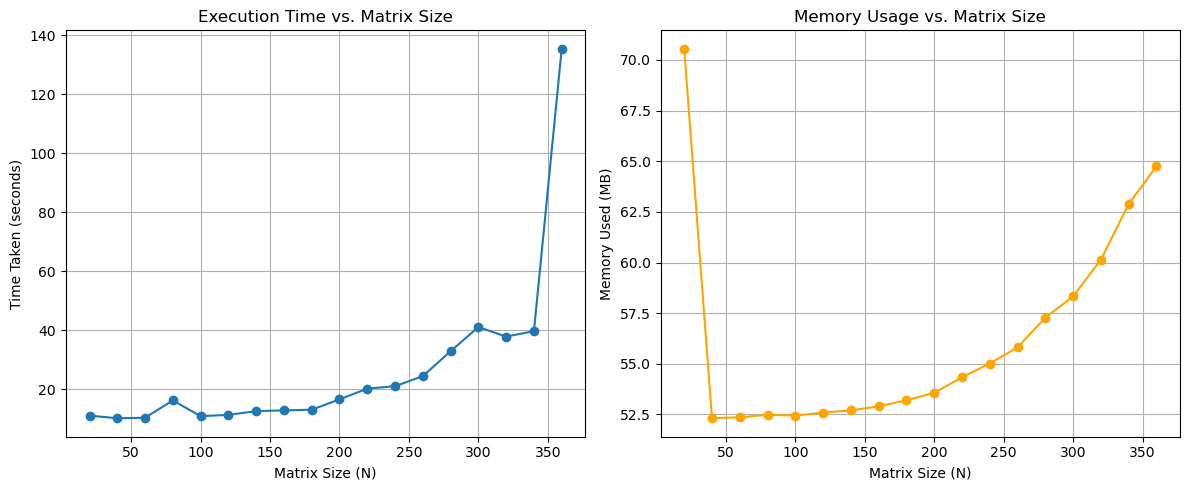

In [6]:
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite
import tracemalloc
import time
import numpy as np
from scipy.sparse import csc_matrix, random as sparse_random
import matplotlib.pyplot as plt

def qubosolver(A, b):
    # Start tracing memory allocations
    tracemalloc.start()
    start_time = time.time()

    # Keep A sparse
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    # Add variables
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()
    for i, j in zip(row, col):
        if i != j:
            bqm.add_interaction(i, j, A[i, j])

    # Use D-Wave's quantum sampler
    sampler = EmbeddingComposite(DWaveSampler(token='DEV-2df6769d96a5ddaec4b4e037d3a7a92833582e9c'))
    response = sampler.sample(bqm, num_reads=100)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    end_time = time.time()
    # Get the current and peak memory usage
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Convert bytes to MB
    memory_used = peak / (1024 ** 2)
    time_taken = end_time - start_time

    print(f"Solution: {sol_sample}")
    print(f"Peak Memory Used: {memory_used:.2f} MB")
    print(f"Time Taken: {time_taken:.6f} seconds")

    return sol_sample, memory_used, time_taken

def test_scalability():
    Ns = []
    times = []
    memories = []
    max_N = 3000   # Adjusted based on D-Wave hardware limitations
    step = 20   # Increment size for N
    density = 0.01  # Density of the sparse matrix

    for N in range(20, max_N + 1, step):
        print(f"\nTesting for N = {N}")
        try:
            # Generate a random sparse binary matrix A
            A = sparse_random(N, N, density=density, format='csc', data_rvs=np.ones).astype(int)

            # Ensure symmetry if required (assuming A should be symmetric)
            A = A + A.T
            A.data[:] = 1  # Ensure all non-zero entries are 1

            # Generate a random binary vector b
            b = np.random.randint(0, 2, size=N)

            # Run the qubosolver
            _, memory_used, time_taken = qubosolver(A, b)

            # Record the results
            Ns.append(N)
            times.append(time_taken)
            memories.append(memory_used)

        except Exception as e:
            print(f"An error occurred: {e}")
            break

    # Plotting the results
    plt.figure(figsize=(12, 5))

    # Plot for Execution Time
    plt.subplot(1, 2, 1)
    plt.plot(Ns, times, marker='o')
    plt.title('Execution Time vs. Matrix Size')
    plt.xlabel('Matrix Size (N)')
    plt.ylabel('Time Taken (seconds)')
    plt.grid(True)

    # Plot for Memory Usage
    plt.subplot(1, 2, 2)
    plt.plot(Ns, memories, marker='o', color='orange')
    plt.title('Memory Usage vs. Matrix Size')
    plt.xlabel('Matrix Size (N)')
    plt.ylabel('Memory Used (MB)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run the scalability test
test_scalability()


Running for matrix size 10x10
Solution: [0 0 1 0 1 1 0 1 1 0]
Memory used: 0.51 MB (Peak: 30.69 MB)
Time: 16.931278 seconds
Running for matrix size 50x50
Solution: [0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0
 1 0 1 1 0 0 1 0 1 0 0 1 0]
Memory used: 0.51 MB (Peak: 30.68 MB)
Time: 18.250063 seconds
Running for matrix size 100x100
Solution: [1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0
 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0
 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0]
Memory used: 0.51 MB (Peak: 30.68 MB)
Time: 17.950402 seconds
Running for matrix size 500x500
Solution: [0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0
 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 1 1 0 

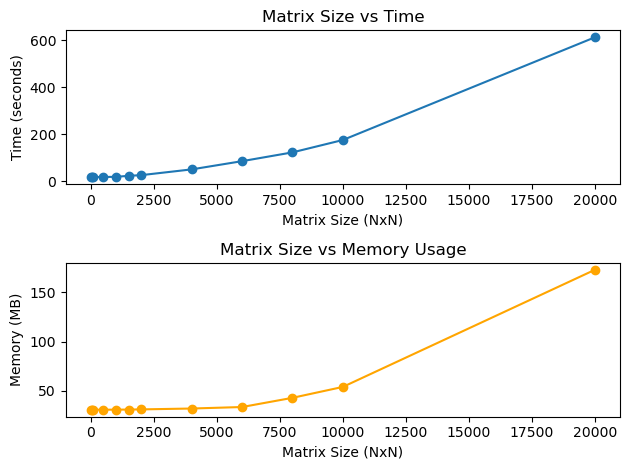

In [4]:
import numpy as np
import time
import tracemalloc
import matplotlib.pyplot as plt
from scipy.sparse import random as sparse_random
from scipy.sparse import csc_matrix
import dimod
from dwave.system import LeapHybridSampler
import os

os.environ['DWAVE_API_TOKEN'] = 'DEV-2df6769d96a5ddaec4b4e037d3a7a92833582e9c'

def qubosolverHr(A, b):
    tracemalloc.start()
    start_time = time.time()
    A = csc_matrix(A)
    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    bqm.add_variables_from({i: b[i] for i in range(len(b))})
    row, col = A.nonzero()  # Get non-zero entries in the matrix A
    for i, j in zip(row, col):
        if i != j:  
            bqm.add_interaction(i, j, A[i, j])

    
    sampler = LeapHybridSampler()
    response = sampler.sample(bqm)
    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    memory_used_mb = current / (1024 ** 2)
    peak_memory_used_mb = peak / (1024 ** 2)
    end_time = time.time()

    # Calculate time taken
    time_taken = end_time - start_time

    # Output solution and performance details
    print(f"Solution: {sol_sample}")
    print(f"Memory used: {memory_used_mb:.2f} MB (Peak: {peak_memory_used_mb:.2f} MB)")
    print(f"Time: {time_taken:.6f} seconds")

    return sol_sample, time_taken, peak_memory_used_mb


def test_scalability():
    matrix_sizes = []
    memory_usage = []
    time_taken = []
    sizes = [10, 50, 100, 500, 1000, 1500, 2000 ,4000, 6000, 8000, 10000 ,20000, 40000, 60000, 80000 ,100000, 120000, 140000, 160000, 180000, 200000]

    try:
        for size in sizes: 
            print(f"Running for matrix size {size}x{size}")
            A = sparse_random(size, size, density=0.01, format='csc', dtype=np.float64)
            A.data = np.ones_like(A.data) 
            b = np.random.randn(size)  # Random linear terms

            sol, t, memory = qubosolverHr(A, b)
            matrix_sizes.append(size)
            time_taken.append(t)
            memory_usage.append(memory)

    except KeyboardInterrupt:
        print("Process interrupted by user.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.plot(matrix_sizes, time_taken, marker='o', label='Time (seconds)')
        plt.xlabel('Matrix Size (NxN)')
        plt.ylabel('Time (seconds)')
        plt.title('Matrix Size vs Time')

        plt.subplot(2, 1, 2)
        plt.plot(matrix_sizes, memory_usage, marker='o', label='Peak Memory Usage (MB)', color='orange')
        plt.xlabel('Matrix Size (NxN)')
        plt.ylabel('Memory (MB)')
        plt.title('Matrix Size vs Memory Usage')

        plt.tight_layout()
        plt.show()

test_scalability()
